# Naive Bayes Approach

## MAX PROBABILITY MODEL

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/meldrumapple/Desktop/Bayes/Final')

In [3]:
#import test and train data set as a result of Data_engineering code
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [4]:
train=train.iloc[:,2: ]
test=test.iloc[:,2:]

In [5]:
# adjust score range to start at zero for varaibles age, income, education for ease of code later
train['Age']=train['Age']-1
train['Income']=train['Income']-1
train['Education']=train['Education']-1
train['GenHlth']=train['GenHlth']-1
test['Age']=test['Age']-1
test['Income']=test['Income']-1
test['Education']=test['Education']-1
test['GenHlth']=test['GenHlth']-1

In [6]:
#split train data set by response variable
train_0=train[train['Diabetes_012']==0]
train_1=train[train['Diabetes_012']==1]
train_2=train[train['Diabetes_012']==2]

likelihood of any given combination of variable reponses: 
$$
p(X|c_i)=\prod_{j=0}^{J}P(x_j|c_i)
$$

In [7]:
#Function that gets likelihood of every combination of class and variable reponse for any variable
def get_like(variable,responses):
    like_0=list()
    like_1=list()
    like_2=list()
    for x in responses: 
        like_0.append(len(train_0[train_0[variable]==x])/len(train_0))
        like_1.append(len(train_1[train_1[variable]==x])/len(train_1))
        like_2.append(len(train_2[train_2[variable]==x])/len(train_2))
    return pd.DataFrame({'like_0':like_0, 'like_1':like_1, 'like_2':like_2})

In [8]:
# get dictionary of dataframe for each variable
likes=list()
#add binary variable dataframes to dict
likes.append(get_like('HighBP',[0,1]))
likes.append(get_like('HighChol',[0,1]))
likes.append(get_like('CholCheck',[0,1]))
likes.append(get_like('BMI', list(range(0,5))))
likes.append(get_like('Smoker',[0,1]))
likes.append(get_like('Stroke',[0,1]))
likes.append(get_like('HeartDiseaseorAttack',[0,1]))
likes.append(get_like('PhysActivity',[0,1]))
likes.append(get_like('Fruits',[0,1]))
likes.append(get_like('Veggies',[0,1]))
likes.append(get_like('HvyAlcoholConsump',[0,1]))
likes.append(get_like('AnyHealthcare',[0,1]))
likes.append(get_like('GenHlth',[0,1]))
likes.append(get_like('GenHlth', list(range(0,6))))
likes.append(get_like('MentHlth', list(range(0,3))))
likes.append(get_like('PhysHlth', list(range(0,3))))
likes.append(get_like('DiffWalk',[0,1]))
likes.append(get_like('Sex',[0,1]))
likes.append(get_like('Age', list(range(0,14))))
likes.append(get_like('Education', list(range(0,7))))
likes.append(get_like('Income', list(range(0,9))))

Priors:
$$
P(c_j)
$$

In [9]:
#Get the priors
pri_0=len(train_0)/len(train)
pri_1=len(train_1)/len(train)
pri_2=len(train_2)/len(train)

condition for classification:
$$
P(c_j)[\prod_{j=0}^{J}P(x_j|c_i)+\alpha]
$$

we added a laplace smoothing factor because some x_i responses are not present in class c_j so they would result in a likelihood of zero which would give a posterior probability of zero for that class

In [10]:
def class_obs(row):
    like_0=1
    like_1=1
    like_2=1
    for i in range(len(row)):
        like_0*=likes[i].iloc[int(row[i]),0].round(15)+0.001 #alpha in case frequency is zero for any variable
        like_1*=likes[i].iloc[int(row[i]),1].round(15)+0.001
        like_2*=likes[i].iloc[int(row[i]),2].round(15)+0.001
    post_0=like_0*(pri_0)
    post_1=like_1*(pri_1)
    post_2=like_2*(pri_2)
    dct={post_0:0,post_1:1,post_2:2}
    return dct[max(post_0,post_1,post_2)]

In [11]:
# now apply to test data:
true_val=test.iloc[:,0].astype(int)
predictors=test.iloc[:,1:].astype(int)

In [12]:
# loop through all rows of the prediction variables and record most likely classfication
preds=list()
for j in range(len(test)):
    preds.append(class_obs(list(predictors.iloc[j, :])))

## Results

In [13]:
results=pd.DataFrame({'dia_hat':preds, 'dia':true_val})
results['correct']=(results['dia_hat']==results['dia'])*1
results['dia_hat'].value_counts()

0    45636
2     5100
Name: dia_hat, dtype: int64

Nothing was classified as prediabetic but that makes sense because there were so few diabetics in the dataset.

In [14]:
# success for 3 class classification
sum(results['correct'])/len(results)

0.8329785556606749

In [15]:
results['bivariate_preds']=(results['dia_hat']!=0)*1
results['bivariate_true']=(results['dia']!=0)*1
results['bi_correct']=(results['bivariate_preds']==results['bivariate_true'])*1

In [16]:
# success for 2 class classification
sum(results['bi_correct'])/len(results)

0.836802270577105

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(results['dia_hat'], results['dia'])

array([[40099,   758,  4779],
       [    0,     0,     0],
       [ 2743,   194,  2163]])

## THRESHOLD MODEL

In [19]:
# rewrite class obs to only classify probabilites above 80%
def class_obs(row):
    like_0=1
    like_1=1
    like_2=1
    for i in range(len(row)):
        like_0*=likes[i].iloc[int(row[i]),0].round(15)+0.001 #alpha in case frequency is zero for any variable
        like_1*=likes[i].iloc[int(row[i]),1].round(15)+0.001
        like_2*=likes[i].iloc[int(row[i]),2].round(15)+0.001
    post_0=like_0*(pri_0)
    post_1=like_1*(pri_1)
    post_2=like_2*(pri_2)
    #put into array and normalize
    posts=np.array([post_0,post_1,post_2])
    posts=posts/sum(posts)
    
    dct={posts[0]:0,posts[1]:1,posts[2]:2}
    if max(posts)>0.8:
        return dct[max(posts)]
    else:
        return -1

In [20]:
# loop through all rows of the prediction variables and record most likely classfication
preds=list()
for j in range(len(test)):
    preds.append(class_obs(list(predictors.iloc[j, :])))

## Results

In [21]:
# Insert results in Dataframe and calulate how many observations were not classified
results2=pd.DataFrame({'dia_hat':preds, 'dia':true_val})
len(results2[results2['dia_hat']==-1])/len(results2)

0.14277830337432987

In [22]:
# finish out the results table
results2=results2[results2['dia_hat']!=-1]
results2['correct']=(results2['dia_hat']==results2['dia'])*1
results2['bivariate_preds']=(results2['dia_hat']!=0)*1
results2['bivariate_true']=(results2['dia']!=0)*1
results2['bi_correct']=(results2['bivariate_preds']==results2['bivariate_true'])*1

In [23]:
# success rate for 3 class classification
sum(results2['correct'])/len(results2)

0.881794352984457

In [24]:
# success rate for 2 class classification
sum(results2['bi_correct'])/len(results2)

0.8832888807136945

In [25]:
confusion_matrix(results2['dia_hat'], results2['dia'])

array([[37316,   609,  3488],
       [    0,     0,     0],
       [  979,    65,  1035]])

## Generating a different cases of the threshold model

In [26]:
def class_obs(row, thresh):
    like_0=1
    like_1=1
    like_2=1
    for i in range(len(row)):
        like_0*=likes[i].iloc[int(row[i]),0].round(15)+0.001 #alpha in case frequency is zero for any variable
        like_1*=likes[i].iloc[int(row[i]),1].round(15)+0.001
        like_2*=likes[i].iloc[int(row[i]),2].round(15)+0.001
    post_0=like_0*(pri_0)
    post_1=like_1*(pri_1)
    post_2=like_2*(pri_2)
    #put into array and normalize
    posts=np.array([post_0,post_1,post_2])
    posts=posts/sum(posts)
    
    dct={posts[0]:0,posts[1]:1,posts[2]:2}
    if max(posts)>thresh:
        return dct[max(posts)]
    else:
        return -1

In [27]:
thresh_success=pd.DataFrame()
thresh_success['threshold']=list()
thresh_success['%unclassified']=list()
thresh_success['success']=list()

In [28]:
# loop through all rows of the prediction variables and record most likely classfication
for i in [0.5,0.6,0.7,0.8,0.9,1]:
    preds=list()
    for j in range(len(test)):
        preds.append(class_obs(list(predictors.iloc[j, :]), i))
    results3=pd.DataFrame({'dia_hat':preds, 'dia':true_val})
    unclassified=len(results3[results3['dia_hat']==-1])/len(results3)
    results3=results3[results3['dia_hat']!=-1]
    results3['correct']=(results3['dia_hat']==results3['dia'])*1
    # success rate for 3 class classification
    success_rate=sum(results3['correct'])/(len(results3)+1)
    thresh_success.loc[len(thresh_success.index)] = [i, unclassified, success_rate]

In [29]:
thresh_success

,threshold,%unclassified,success
0,0.5,0.012082,0.837044
1,0.6,0.049176,0.849695
2,0.7,0.091198,0.864650
3,0.8,0.142778,0.881774
4,0.9,0.224535,0.906240
5,1.0,1.000000,0.000000


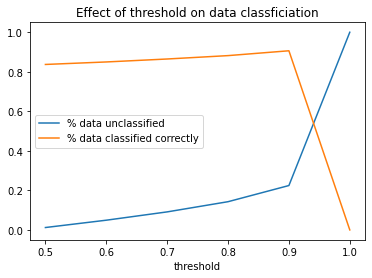

In [34]:
plt.plot(thresh_success['threshold'],thresh_success['%unclassified'], label='% data unclassified')
plt.plot(thresh_success['threshold'],thresh_success['success'], label = "% data classified correctly")
plt.title('Effect of threshold on data classficiation')
plt.xlabel('threshold')
plt.legend()
plt.show()